In [ ]:
# Machine translation is precisely what Transformer was developed for

In [1]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-04-03 08:09:20--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  1.87MB/s    in 1.3s    

2023-04-03 08:09:21 (1.87 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [2]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
  lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
  english, spanish = line.split("\t")
  spanish = "[start] " + spanish + " [end]"
  text_pairs.append((english, spanish))

In [ ]:

text_pairs

In [ ]:
# shuffle and split 

In [4]:
import random 
print(random.choice(text_pairs))

('He told me the truth.', '[start] Él me dijo la verdad. [end]')


In [5]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

In [6]:
# Vectorizing the English and Spanish text pairs

import tensorflow as tf 
import string 
import re 

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

In [7]:
def custom_standardisation(input_string):
  lowercase = tf.strings.lower(input_string)
  return tf.strings.regex_replace(lowercase , f"{re.escape(strip_chars)}", "")

In [ ]:
# vectorization

In [8]:
from tensorflow.keras import layers
vocab_size = 15000
sequence_length = 20

# english vectorization
source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size, 
    output_mode = "int",
    output_sequence_length=sequence_length
)


# spanish vectorization
target_vectorization = layers.TextVectorization(
    max_tokens = vocab_size ,
    output_mode = "int" ,
    output_sequence_length = sequence_length + 1,
    standardize = custom_standardisation,
)


train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]

source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

In [9]:
# Preparing datasets for the translation task

batch_size = 64

def format_dataset(eng , spa) :
  eng = source_vectorization(eng)
  spa = target_vectorization(spa)

  return ({
      "english": eng , 
      "spanish": spa[:, :-1],
  }, spa[:, 1:])


def make_dataset(pairs):
  eng_texts , spa_texts = zip(*pairs)
  eng_texts = list(eng_texts)
  spa_texts = list(spa_texts)
  dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset, num_parallel_calls=4)
  return dataset.shuffle(2048).prefetch(16).cache()

In [10]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [11]:
for inputs , targets in train_ds.take(1):
  print(f"inputs['english'].shape: {inputs['english'].shape}")
  print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
  print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


In [12]:
# Sequence-to-sequence learning with RNNs

"""
 the way to use RNN for seq2seq learning is make the RNN layer output the entire sequence at each time step
 the issues here are :
   - 1 : the input sequence should always be the same as target(could deal wiht it with padding)
   - 2 : the layer will look at token 0...N in the source sequence in order to predict token N in the target sequence
 In a proper sequence-to-sequence setup (see figure 11.13), you would first use an
 RNN (the encoder) to turn the entire source sequence into a single vector (or set of
 vectors). This could be the last output of the RNN, or alternatively, its final internal
 state vectors. Then you would use this vector (or vectors) as the initial state of another
 RNN (the decoder), which would look at elements 0…N in the target sequence, and
 try to predict step N+1 in the target sequence.

 """

'\n the way to use RNN for seq2seq learning is make the RNN layer output the entire sequence at each time step\n the issues here are :\n   - 1 : the input sequence should always be the same as target(could deal wiht it with padding)\n   - 2 : the layer will look at token 0...N in the source sequence in order to predict token N in the target sequence\n In a proper sequence-to-sequence setup (see figure 11.13), you would first use an\n RNN (the encoder) to turn the entire source sequence into a single vector (or set of\n vectors). This could be the last output of the RNN, or alternatively, its final internal\n state vectors. Then you would use this vector (or vectors) as the initial state of another\n RNN (the decoder), which would look at elements 0…N in the target sequence, and\n try to predict step N+1 in the target sequence.\n\n '

In [13]:
# GRU-based encoder

from tensorflow import keras 
embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim , mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

In [14]:
# RU-based decoder and the end-to-end model
past_target = keras.Input(shape=(None ,),  dtype="int64", name="spanish")
x = layers.Embedding(vocab_size , embed_dim , mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

In [15]:
#Training our recurrent sequence-to-sequence model
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 [==============================] - 145s 97ms/step - loss: 4.6697 - accuracy: 0.3282 - val_loss: 3.8470 - val_accuracy: 0.4070
Epoch 2/15
1302/1302 [==============================] - 109s 83ms/step - loss: 3.7453 - accuracy: 0.4237 - val_loss: 3.2544 - val_accuracy: 0.4775
Epoch 3/15
1302/1302 [==============================] - 109s 83ms/step - loss: 3.2856 - accuracy: 0.4739 - val_loss: 2.9200 - val_accuracy: 0.5205
Epoch 4/15
1302/1302 [==============================] - 108s 83ms/step - loss: 2.9521 - accuracy: 0.5112 - val_loss: 2.6814 - val_accuracy: 0.5529
Epoch 5/15
1302/1302 [==============================] - 108s 83ms/step - loss: 2.6915 - accuracy: 0.5403 - val_loss: 2.5089 - val_accuracy: 0.5765
Epoch 6/15
1302/1302 [==============================] - 108s 83ms/step - loss: 2.4810 - accuracy: 0.5649 - val_loss: 2.3870 - val_accuracy: 0.5934
Epoch 7/15
1302/1302 [==============================] - 119s 91ms/step - loss: 2.3020 - accuracy: 0.5861 - val_loss: 2

In [17]:
# Translating new sentences with our RNN encoder and decoder

import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

In [18]:
def decode_sequence(input_sentence):
  tokenized_input_sentence = source_vectorization([input_sentence])
  decoded_sentence = "[start]"
  for i in range(max_decoded_sentence_length):
    tokenized_target_sentence = target_vectorization([decoded_sentence])
    next_token_predictions = seq2seq_rnn.predict([tokenized_input_sentence, tokenized_target_sentence])
    sampled_token_index = np.argmax(next_token_predictions[0, i, :])
    sampled_token = spa_index_lookup[sampled_token_index]
    decoded_sentence += " " + sampled_token
    if sampled_token == "[end]":
      break 
  return decoded_sentence

In [19]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
  input_sentence = random.choice(test_eng_texts)
  print("-")
  print(input_sentence)
  print(decode_sequence(input_sentence))

-
Would you mind telling me what this is about?
1/1 [==============================] - 0s 35ms/step
[start] ¿me importaría decir qué es esto? [end]
-
Do you have a license to sell liquor?
1/1 [==============================] - 0s 36ms/step
[start] ¿tienes una oportunidad de [UNK] [UNK] [end]
-
It is as clear to me as if it were yesterday.
1/1 [==============================] - 0s 23ms/step
[start] es tan [UNK] como si me ayer. [end]
-
You've got to be crazy to do something like that.
1/1 [==============================] - 0s 23ms/step
[start] tienes que hacer algo para hacer eso. [end]
-
Bunnies are so cute.
1/1 [==============================] - 0s 22ms/step
[start] los [UNK] son tan [UNK] [end]
-
You should not despise a man because he is poorly paid.
1/1 [==============================] - 0s 26ms/step
[start] no deberías despreciar a un hombre tan [UNK] como un [UNK] [end]
-
I often went to the movies with my father.
1/1 [==============================] - 0s 25ms/step
[start] a menu

In [ ]:
"""
We could use a deep stack of
recurrent layers for both the encoder and the decoder (note that for the decoder, this
makes state management a bit more involved). We could use an LSTM instead of a GRU.
And so on.

the RNN approach to sequence-to-sequence
learning has a few fundamental limitations:
 - The source sequence representation has to be held entirely in the encoder state
  vector(s), which puts significant limitations on the size and complexity of the
  sentences you can translate. It’s a bit as if a human were translating a sentence
  entirely from memory, without looking twice at the source sentence while pro-
  ducing the translation.

 - RNNs have trouble dealing with very long sequences, since they tend to pro-
  gressively forget about the past—by the time you’ve reached the 100th token in
  either sequence, little information remains about the start of the sequence.
"""

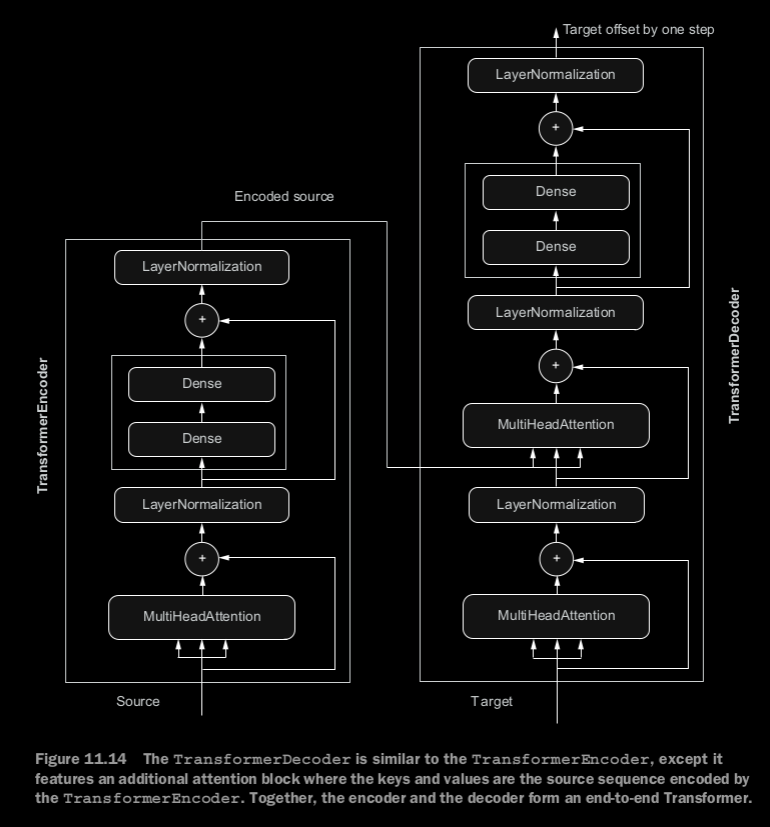

In [40]:
# The TransformerDecoder
import tensorflow as tf
from tensorflow import keras
from keras import layers 

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ], name="decoder_dense_proj")
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        # Replicate it along the batch axis to get a matrix of shape (batch_size, sequence_length, sequence_length).
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)
    
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        # Retrieve padding_mask from input mask.
        if mask is not None:
            # Prepare the input mask (that describes padding locations in the target sequence).
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = causal_mask
        # Merge the two masks together.
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)    

In [34]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim,
            output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length,
            output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "input_dim": self.input_dim,
            "sequence_length": self.sequence_length,
        })
        return config


In [50]:
class TransformerEncoder(layers.Layer):
  def __init__(self , embed_dim , dense_dim,  num_heads , **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim 
    self.num_heads = num_heads 
    self.attention = layers.MultiHeadAttention(
        num_heads = num_heads , key_dim = embed_dim )
    
    self.dense_proj = keras.Sequential([
        layers.Dense(dense_dim, activation="relu"),
        layers.Dense(embed_dim),
    ], name="encoder_dense_proj")
    self.dense_proj.build(input_shape=(None, embed_dim))


    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs , mask=None):
      if mask is not None :
        mask = mask[:, tf.newaxis, :]

      attention_output = self.attention(
          inputs , inputs , attention_mask = mask)
      
      proj_input = self.layernorm_1(inputs + attention_output)

      proj_output = self.dense_proj(proj_input)

      return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
      config = super().get_config()
      config.update({
          "embed_dim": self.embed_dim,
          "num_heads": self.num_heads,
          "dense_dim": self.dense_dim,
      })
      return config 



In [ ]:
# positional embedding layer
"""
The idea behind positional encoding is very simple: to give the model access to word-
order information, we’re going to add the word’s position in the sentence to each word
embedding. Our input word embeddings will have two components: the usual word
vector, which represents the word independently of any specific context, and a posi-
tion vector, which represents the position of the word in the current sentence.
we’ll learn position-
embedding vectors the same way we learn to embed word indices. We’ll then proceed
to add our position embeddings to the corresponding word embeddings, to obtain a
position-aware word embedding. This technique is called “positional embedding.”
Let’s implement it.
"""

In [51]:
# end-to-end Transformer
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [52]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30


1302/1302 [==============================] - 90s 65ms/step - loss: 4.3522 - accuracy: 0.3688 - val_loss: 3.6260 - val_accuracy: 0.4363
Epoch 2/30
1302/1302 [==============================] - 71s 55ms/step - loss: 3.7060 - accuracy: 0.4394 - val_loss: 3.3451 - val_accuracy: 0.4751
Epoch 3/30
1302/1302 [==============================] - 71s 54ms/step - loss: 3.4673 - accuracy: 0.4728 - val_loss: 3.1623 - val_accuracy: 0.5040
Epoch 4/30
1302/1302 [==============================] - 71s 54ms/step - loss: 3.3046 - accuracy: 0.4954 - val_loss: 3.0620 - val_accuracy: 0.5166
Epoch 5/30
1302/1302 [==============================] - 71s 55ms/step - loss: 3.1915 - accuracy: 0.5112 - val_loss: 3.0040 - val_accuracy: 0.5280
Epoch 6/30
1302/1302 [==============================] - 71s 54ms/step - loss: 3.1120 - accuracy: 0.5235 - val_loss: 2.9942 - val_accuracy: 0.5331
Epoch 7/30
1302/1302 [==============================] - 73s 56ms/step - loss: 3.0513 - accuracy: 0.5330 - val_loss: 2.9772 - val_accura

In [53]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

In [55]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        
        # Sample the next token.
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        
        # Convert the next token prediction to a string, and append it to decoded_sentence.
        decoded_sentence += " " + sampled_token
        
        # Exit condition if [end] is reached.
        if sampled_token == "[end]":
            break
            
    return decoded_sentence




In [57]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = input("Enter sentence to translate: ")
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

Enter sentence to translate: yesterday , i was at school
-
yesterday , i was at school
[start] ayer tuve la oficina a las [UNK] [end]
Enter sentence to translate: the sky is blue 
-
the sky is blue 
[start] el [UNK] es azul. [end]
Enter sentence to translate: i love this song
-
i love this song
[start] no me gusta esta canción para ti. [end]
Enter sentence to translate: do you know this flower's name ?
-
do you know this flower's name ?
[start] ¿tienes una vida en [UNK] [end]
Enter sentence to translate: what are you doing ?
-
what are you doing ?
[start] ¿qué estás [UNK] [end]
